In [1]:
import math
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from scipy.special import inv_boxcox
from wordcloud import WordCloud
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [2]:
def load_dataset():
    return pd.read_csv('data/data.csv')

In [3]:
df = load_dataset()

In [17]:
df.groupby(['brand_title', 'brand_type']).size().reset_index()[['brand_title', 'brand_type']].to_csv('data/brands.csv', index=False)

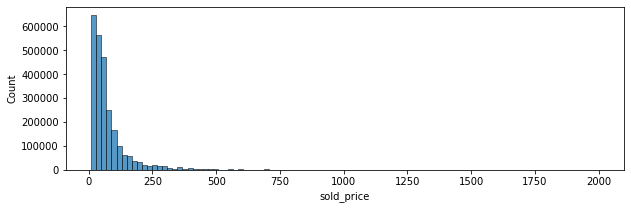

In [47]:
plt.figure(figsize=(10, 3))
sns.histplot(data=df[df['sold_price'] < 2000], x='sold_price', bins=100)
plt.show()

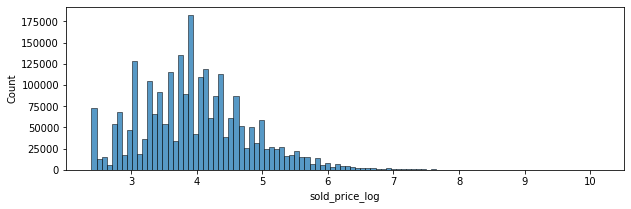

In [50]:
df['sold_price_log'] = df['sold_price'].apply(np.log1p)

plt.figure(figsize=(10, 3))
sns.histplot(data=df, x='sold_price_log', bins=100)
plt.show()

## Data Exploration

### Data Shape and 5 example rows

In [39]:
df.shape

(1144486, 18)

In [ ]:
df.head()

### Data Types

In [ ]:
df.dtypes

### Missing Values

In [ ]:
df.isnull().sum()

### Duplicate rows

In [4]:
def remove_duplicates(df):
    return df.copy().drop_duplicates('product_id')

In [5]:
df = remove_duplicates(df)

### Remove null

In [6]:
def remove_nulls(df):
    return df.copy().dropna(axis=0, subset=['thirdlevel_title_']).dropna(axis=0, subset=['original_price'])

In [7]:
df = remove_nulls(df)

### Price variable statistics

In [ ]:
df.sold_price.describe().apply(lambda x: format(x, 'f'))

### Brands

Best seller brands

In [57]:
df['sold_price'].max()

25000.0

In [58]:
df['sold_price'].min()

10.0

In [59]:
df['sold_price'].mean()

82.41971702075736

In [60]:
df['sold_price'].std()

165.04702078670744

In [ ]:
df['sold_price'].std()

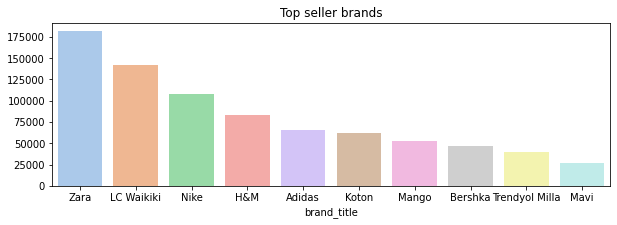

In [56]:
top_10_brands = df.groupby(['brand_title'])['brand_title'].count().sort_values(ascending=False)[:10]

plt.figure(figsize=(10, 3))
sns.barplot(x=top_10_brands.index, y=top_10_brands.values, palette='pastel')
plt.title('Top seller brands')
plt.show()

Most expensive brands

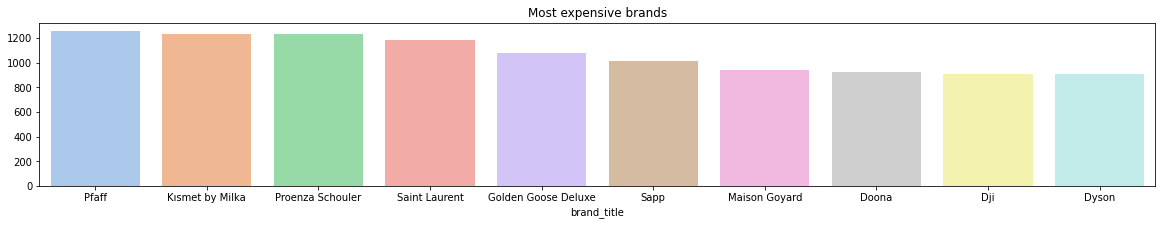

In [55]:
filtered_df = df.groupby(['brand_title']).filter(lambda brand: len(brand) > 10)

most_expensive_brands = filtered_df.groupby(['brand_title'])['sold_price'].mean().sort_values(ascending=False)[:10]

plt.figure(figsize=(20, 3))
sns.barplot(x=most_expensive_brands.index, y=most_expensive_brands.values, palette='pastel')
plt.title('Most expensive brands')
plt.show()

Shipping vs Price

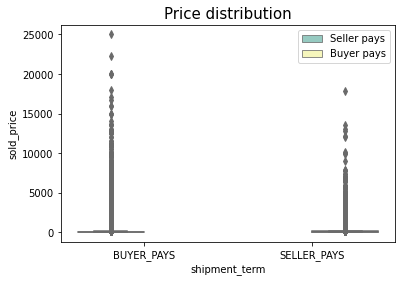

In [10]:
ax = sns.boxplot(x=df['shipment_term'],y=df['sold_price'],palette="Set3",hue=df['shipment_term'])
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Seller pays", "Buyer pays"])
plt.title('Price distribution', fontsize=15)
plt.show()

### Wordclouds

In [267]:
def text_preprocess(value, stopwords):
    value = value.replace('\\r', ' ')
    value = value.replace('\\"', ' ')
    value = value.replace('\\n', ' ')
    value = ' '.join(e for e in value.split() if e not in stopwords)
    return value.lower().strip()


def generate_word_cloud(series):
    df['description'] = df['description'].astype(str)
    with open('stopwords.txt', 'r') as f:
        stopwords = [word.strip() for word in f.readlines()]
    
    wordcloud = WordCloud(collocations=False).generate(' '.join(text_preprocess(value, stopwords) for value in series))
    plt.figure(figsize = (12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'WordCloud for {series.name}')
    plt.show()

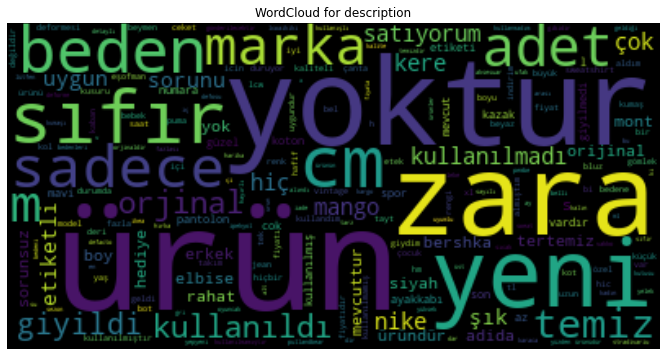

In [268]:
generate_word_cloud(df['description'])

## Outliers

In [5]:
def show_outliers(series):
    sns.set(rc={'figure.figsize':(9,6)})
    sns.boxplot(series)
    plt.title('Outliers')
    plt.show()

In [10]:
def is_outlier(s):
    quartile_1 = np.round(s.quantile(0.25), 2)
    quartile_3 = np.round(s.quantile(0.75), 2)
    iqr = np.round(quartile_3 - quartile_1, 2)
    lower_th = quartile_1 - (iqr * 1.5)
    higher_th = quartile_3 + (iqr * 1.5)
    
    return ~s.between(lower_th, higher_th)

In [11]:
def remove_outliers(df, by = 'sold_price', filtered_column = 'thirdlevel_title_'):
    
    copy_df = df.copy()
    
    return copy_df[~copy_df.groupby(filtered_column)[by].apply(is_outlier)]

In [14]:
df = remove_outliers(df)

In [15]:
df.shape

(2232468, 18)

### Boxcox transformation

In [16]:
boxcox_lambda = None

def boxcox_transform(series):
    fitted_data, lmd = stats.boxcox(series)
    
    boxcox_lambda = lmd
    return fitted_data

In [17]:
def price_boxcox_transform(df, price_column='sold_price', c_name='sold_price_boxcox', plot=False):
    normalized_price = boxcox_transform(df[price_column])
    
    df[c_name] = normalized_price
    
    if plot:
        fig, ax = plt.subplots(1, 2)

        sns.kdeplot(df[price_column], label = "Non-Normal", color ="red", shade = True, ax = ax[0])
        sns.kdeplot(normalized_price, label = "Normal", color ="green", shade = True, ax = ax[1])

        fig.set_figheight(5)
        fig.set_figwidth(10)
        
        ax[0].legend(loc = 'upper right')
        ax[1].legend(loc = 'upper right')
        plt.show()
    
    return df

In [18]:
def normalize_continous_vars(df, columns = None, plot = False):
    columns = columns or ['sold_price_mean', 'original_price', 'original_price_mean', 'discount_rate']
    
    for col in columns:
        df = price_boxcox_transform(df, price_column = col, c_name = col + '_boxcox', plot=plot)
        
    return df

In [25]:
df = normalize_continous_vars(df)

In [26]:
df

,product_id,seller_id,brand_id,brand_title,brand_type,category_id,condition,shipment_term,product_status,star,...,original_price,price,sold_price,original_price_mean,sold_price_mean,discount_rate,sold_price_mean_boxcox,original_price_boxcox,original_price_mean_boxcox,discount_rate_boxcox
0,10026506,1545373,171,İpekyol,POPULAR,112,GENTLY_WORN,BUYER_PAYS,SOLD,5.0,...,150.0,30,24.0,144.651757,35.287040,0.756055,1.169112,3.459397,1.691024,-0.142945
1,11979929,102583,32,Atmosphere,ECONOMICAL,78,GENTLY_WORN,SELLER_PAYS,SOLD,5.0,...,80.0,33,24.0,318.956388,65.262558,0.795387,1.196422,3.160353,1.731781,-0.130342
2,28019784,1091450,195,LC Waikiki,ECONOMICAL,215,LIKE_NEW,BUYER_PAYS,SOLD,5.0,...,50.0,20,16.0,96.922717,21.703372,0.776075,1.135579,2.916496,1.662492,-0.136888
3,31926856,4037916,99,Deriden,POPULAR,132,LIKE_NEW,BUYER_PAYS,SOLD,5.0,...,250.0,90,65.0,257.478243,68.622115,0.733484,1.198109,3.681423,1.722442,-0.148963
4,40659058,5600654,192,Lacoste,POPULAR,112,GENTLY_WORN,BUYER_PAYS,SOLD,5.0,...,575.0,65,52.0,144.651757,35.287040,0.756055,1.169112,4.007066,1.691024,-0.142945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2556967,123014253,1732333,318,Swatch,POPULAR,85,LIKE_NEW,BUYER_PAYS,SOLD,5.0,...,500.0,300,180.0,759.128967,130.425226,0.828191,1.214615,3.955376,1.760070,-0.117460
2556968,123122819,26657542,3586,Remington,POPULAR,486,LIKE_NEW,SELLER_PAYS,SOLD,5.0,...,230.0,110,100.0,276.249644,84.190055,0.695239,1.204317,3.646397,1.725634,-0.157431
2556969,130244686,19381013,3832,Neutrogena,POPULAR,429,NEW_WITH_TAGS,BUYER_PAYS,SOLD,5.0,...,65.0,40,28.0,96.201845,35.707266,0.628830,1.169776,3.054855,1.661897,-0.167931
2556970,132510780,10785227,360,Zara,POPULAR,214,LIKE_NEW,BUYER_PAYS,SOLD,5.0,...,80.0,35,35.0,107.521306,27.605159,0.743259,1.153814,3.160353,1.670504,-0.146457


### Log Price

In [ ]:
def price_log_transform(df, price_column = 'sold_price', plot = False):
    normalized_price = df[price_column].apply(lambda price: np.log1p(price))
    
    df[c_name] = normalized_price
    
    if plot:
        fig, ax = plt.subplots(1, 2)

        sns.distplot(df[price_column], hist = False, kde = True,
                    kde_kws = {'shade': True, 'linewidth': 2}, 
                    label = "Non-Normal", color ="green", ax = ax[0])

        sns.distplot(normalized_price, hist = False, kde = True,
                    kde_kws = {'shade': True, 'linewidth': 2}, 
                    label = "Normal", color ="green", ax = ax[1])

        plt.legend(loc = "upper right")
        fig.set_figheight(5)
        fig.set_figwidth(10)
        plt.show()
    
    return df

### One Hot Encoding

In [27]:
def encode_and_bind(df, column):
    dummies = pd.get_dummies(df[column])
    res = pd.concat([df, dummies], axis=1)
    return res

In [28]:
def encode_categorical_features(df, features = None):
    features = features or ['thirdlevel_title_', 'brand_type', 'condition', 'shipment_term']
    
    for feature in features:
        df = encode_and_bind(df, feature)
        
    return df

In [29]:
df = encode_categorical_features(df)

## Feature creation

### Third Level Category Original Price Mean

In [20]:
def add_price_mean(df, price_column, by='thirdlevel_title_'):
    col_name = price_column + '_mean'
    
    df[col_name] = df.groupby(by)[price_column].transform(np.mean)
    return df

In [21]:
df = add_price_mean(df, 'original_price')

In [22]:
df = add_price_mean(df, 'sold_price')

### Discount rate mean for third level title

In [23]:
def discount_rate(df):
    return (df['original_price_mean'] - df['sold_price_mean']) / df['original_price_mean']

In [24]:
df['discount_rate'] = discount_rate(df)

### Description Word Count

In [30]:
def add_word_count(df, column_name = 'description_wc', plot = False):
    df['description'] = df['description'].astype(str)
    df['description_wc'] = df['description'].apply(lambda desc: len(desc.split()))
    
    if plot:
        plt.figure(figsize=(10,3))
        sns.kdeplot(df['description_wc'])
        plt.title('Plot of the word count for each item description')
        plt.xlabel('Number of words in each description')
        plt.show()
    
    return df

In [31]:
df = add_word_count(df)

## **Correlation among variables**

In [63]:
def show_correlation_heatmap(df, columns = None):
    columns = columns or ['star', 'original_price', 'sold_price', 'price']
    
    corr_matrix = df[columns].corr()
    
    fig, ax = plt.subplots(figsize=(18, 9))
    ax.set_title('Correlation Matrix', fontsize = 18)
    sns.heatmap(corr_matrix, annot=True, ax=ax)
    plt.show()

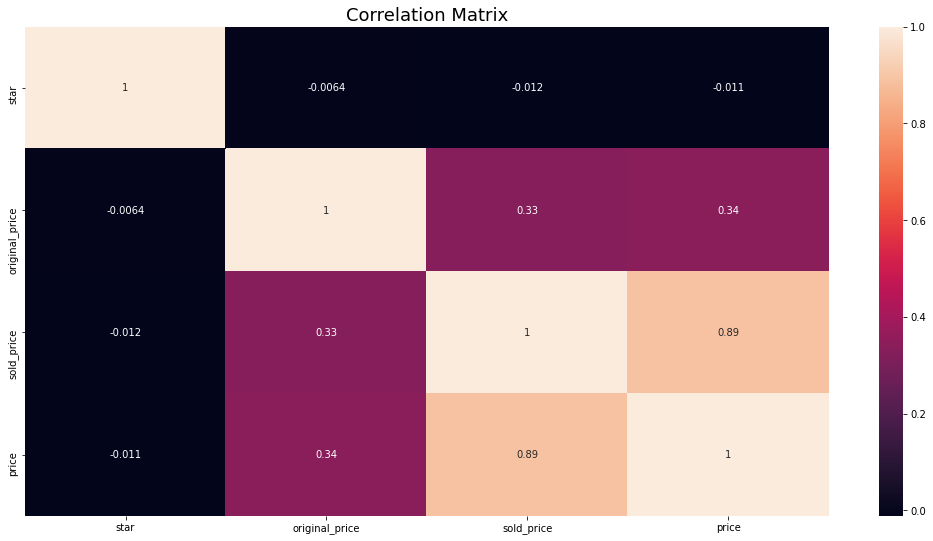

In [64]:
show_correlation_heatmap(df)

## Model Creation

In [6]:
def prepare_dataset():
    df = load_dataset()
    df = remove_duplicates(df)
    df = remove_nulls(df)
    df = remove_outliers(df)
    df = price_boxcox_transform(df)
    df = encode_categorical_features(df)
    df = add_word_count(df)
    
    return df

In [73]:
df = prepare_dataset()

In [32]:
def create_inputs(df, excluded_columns = None, dependent_column = 'sold_price', test_size = 0.20):
    excluded_columns = excluded_columns or [
        'product_id', 'seller_id', 'brand_id', 'brand_title', 'brand_type', 'category_id', 'condition', 'shipment_term', 'product_status', 'star',
        'description', 'zerolevel_title', 'firstlevel_title',
        'secondlevel_title', 'thirdlevel_title_', 'price',
        'sold_price', 'original_price', 'original_price_mean', 'sold_price_mean', 'discount_rate'
    ]
    
    df_train, df_test = train_test_split(df, test_size=test_size)
    
    train_categories = df_train['thirdlevel_title_'].unique()
    df_test = df_test[df_test['thirdlevel_title_'].isin(train_categories)]
    
    X_train = df_train.drop(excluded_columns, axis=1)
    X_test = df_test.drop(excluded_columns, axis=1)
    y_train = df_train[dependent_column]
    y_test = df_test[dependent_column]
    
    return X_train, y_train, X_test, y_test

In [33]:
def create_model(df, model_factory=LinearRegression):
    
    X_train, y_train, X_test, y_test = create_inputs(df)
    
    model = model_factory()
    model.fit(X_train, y_train)
    
    return model, X_train, y_train, X_test, y_test    

In [34]:
def rmsle_score(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

In [35]:
def rmse_score(y,y_pred):
    return math.sqrt(mean_squared_error(y, y_pred))

In [36]:
def calc_model_error(model, X_test, y_test, error_func = rmse_score):
    # predictions = model.predict(X_test)
    # denormalized_preds = inv_boxcox(predictions, boxcox_lambda)
    # denormalized_test = inv_boxcox(y_test, boxcox_lambda)
    
    # return error_func(denormalized_test, denormalized_preds)
    
    return error_func(y_test, model.predict(X_test))

In [37]:
def create_calc_model_error(df, **kwargs):
    error_func = kwargs.pop('error_func', rmse_score)

    model, X_train, y_train, X_test, y_test = create_model(df)
    return calc_model_error(model, X_test, y_test, error_func)

In [58]:
def calc_cross_val_score(df):
    X_train, y_train, X_test, y_test = create_inputs(df)
    
    model = LinearRegression()
    
    scores = cross_val_score(model, X_train, y_train, scoring=make_scorer(mean_squared_error, greater_is_better = False))
    return scores

In [38]:
def r_square(y_test, predicted):
    return r2_score(y_test, predicted)    

In [109]:
create_calc_model_error(df, model_factory=Lasso, error_func=mean_squared_error)

2707.1407810784635

In [41]:
df

,product_id,seller_id,brand_id,brand_title,brand_type,category_id,condition,shipment_term,product_status,star,...,ECONOMICAL,LUX,POPULAR,ULTRA_LUX,GENTLY_WORN,LIKE_NEW,NEW_WITH_TAGS,BUYER_PAYS,SELLER_PAYS,description_wc
0,10026506,1545373,171,İpekyol,POPULAR,112,GENTLY_WORN,BUYER_PAYS,SOLD,5.0,...,0,0,1,0,1,0,0,1,0,3
1,11979929,102583,32,Atmosphere,ECONOMICAL,78,GENTLY_WORN,SELLER_PAYS,SOLD,5.0,...,1,0,0,0,1,0,0,0,1,5
2,28019784,1091450,195,LC Waikiki,ECONOMICAL,215,LIKE_NEW,BUYER_PAYS,SOLD,5.0,...,1,0,0,0,0,1,0,1,0,14
3,31926856,4037916,99,Deriden,POPULAR,132,LIKE_NEW,BUYER_PAYS,SOLD,5.0,...,0,0,1,0,0,1,0,1,0,33
4,40659058,5600654,192,Lacoste,POPULAR,112,GENTLY_WORN,BUYER_PAYS,SOLD,5.0,...,0,0,1,0,1,0,0,1,0,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2556967,123014253,1732333,318,Swatch,POPULAR,85,LIKE_NEW,BUYER_PAYS,SOLD,5.0,...,0,0,1,0,0,1,0,1,0,11
2556968,123122819,26657542,3586,Remington,POPULAR,486,LIKE_NEW,SELLER_PAYS,SOLD,5.0,...,0,0,1,0,0,1,0,0,1,11
2556969,130244686,19381013,3832,Neutrogena,POPULAR,429,NEW_WITH_TAGS,BUYER_PAYS,SOLD,5.0,...,0,0,1,0,0,0,1,1,0,10
2556970,132510780,10785227,360,Zara,POPULAR,214,LIKE_NEW,BUYER_PAYS,SOLD,5.0,...,0,0,1,0,0,1,0,1,0,4


In [39]:
model, X_train, y_train, X_test, y_test = create_model(df, model_factory=Ridge)

In [40]:
calc_model_error(model, X_test, y_test, mean_squared_error)

1718.668655719812

In [140]:
r_square(y_test, model.predict(X_test))

0.5358416484865853

In [123]:
b = model.predict(X_test)

In [206]:
b_ = inv_boxcox(b, -0.0760369)

In [207]:
a_ = inv_boxcox(a, -0.0760369)

In [217]:
r2 = r2_score(a_, b_)

In [99]:
r2_score(a, b)

0.31574233230527693

In [97]:
1 - (1-r2)*(len(b)-1)/(len(b)-X_test.shape[1]-1)

0.3137359253100003

In [69]:
from sklearn.linear_model import Ridge

create_calc_model_error(df, model_factory=Ridge, error_func=mean_squared_error)

0.24510654822731567

In [70]:
from sklearn.linear_model import Lasso

create_calc_model_error(df, model_factory=Lasso, error_func=mean_squared_error)

0.24754096148559368

In [ ]:
def create_ols_model(X_train, y_train):
    X2 = sm.add_constant(np.asarray(X_train, dtype=float))
    est = sm.OLS(np.asarray(y_train, dtype=float), X2)
    est2 = est.fit()
    return est2

In [ ]:
X_train, y_train, X_test, y_test = create_inputs(df)

model = create_ols_model(X_train, y_train)

print(model.summary())

calc_model_error(model, X_test, y_test)

In [ ]:
def backwards_elimination(df):
    X_train, y_train, X_test, y_test = create_inputs(df)
    cols = list(X_train.columns)
    
    print(len(X_train.columns))
    
    pmax = 1
    while (len(cols)>0):
        X_1 = X_train[cols]
        X_1 = sm.add_constant(X_1)
        model = sm.OLS(y_train, X_1).fit()
        print(model.summary())
        p = pd.Series(model.pvalues.values, index = cols)      
        pmax = max(p)
        feature_with_p_max = p.idxmax()
        if(pmax>0.05):
            print('Removed feature: ', feature_with_p_max)
            print('Remaining feature count', len(cols))
            cols.remove(feature_with_p_max)
        else:
            break
            
    return cols

In [ ]:
backwards_elimination(df)

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

print('Intercept: \n', model.intercept_)
print('Coefficients: \n', model.coef_)

In [ ]:
from sklearn.linear_model import Lasso

model = Lasso(alpha=0.5)
model.fit(X_train, y_train)

print('Intercept: \n', model.intercept_)
print('Coefficients: \n', model.coef_)

In [ ]:
format(rmse_score(y_test, model.predict(X_test)), 'f')

In [ ]:
X2 = sm.add_constant(np.asarray(X_train, dtype=float))
est = sm.OLS(np.asarray(y_train, dtype=float), X2)
est2 = est.fit()
print(est2.summary())

In [ ]:
df['sold_price'].min()